# Detecting anomalies in your images using the mobilenet Pipeline 

The following tutorial shows you 

1. How to deploy a wallaroo pipeline using faster rcnn mobilenet model created in step 2
2. Create a post-process-anomoly-detection.py file and add logic for detecting anomolies
3. We will add the post-process-anomoly-detection.py as a step in the pipeline
2. Then run inference on a sample image
3. Draw the detected objects, their bounding boxes, their classifications, and the confidence of the classifications on the provided image.
4. Note how many anomolies were detected



In [1]:
import torch
import pickle
import wallaroo
import os
import numpy as np
import json
import requests
import time
import pandas as pd
from CVDemoUtils import CVDemo


In [2]:
wl = wallaroo.Client()

In [3]:
model_name = 'mobilenet'
mobilenet_model = wl.upload_model('mobilenet', "models/mobilenet.pt.onnx")

Next we will add our post processing anomoly detection file called post-process-anomoly-detection.py.  <b>Predictions that are lower than 75% we will consider anomalies and need to be inspected.</b>

In [4]:
module_anomoly_detection = wl.upload_model("post-process-anomoly-detection", "./post-process-anomoly-detection.py").configure('python')

In [5]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("8Gi").build()

In [6]:
pipeline_name = 'anomoly-pp'
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(mobilenet_model) \
            .add_model_step(module_anomoly_detection)

pipeline.deploy(deployment_config = deployment_config)

Waiting for deployment - this will take up to 45s ....... ok


name,anomoly-pp
created,2022-11-04 10:28:28.109815+00:00
last_updated,2022-12-14 13:27:33.745876+00:00
deployed,True
tags,
steps,mobilenet


In [7]:
#pipeline.undeploy()

In [8]:
time.sleep(2) # needed to allow the pipeline to settle in.

## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

In [10]:
# The size the image will be resized to
width = 640
height = 480

imagePath = 'data/images/input/example/example_01.jpg'

cvDemo = CVDemo()

# The image width and height needs to be set to what the model was trained for.  In this case 640x480.
tensor, resizedImage = cvDemo.loadImageAndResize(imagePath, width, height)

# get npArray from the tensorFloat
npArray = tensor.cpu().numpy()

#creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
dictData = {"tensor": npArray.tolist()}


# Run inference using the SDK 

Now lets have the model detect the objects on the image by running inference and extracting the results 

In [11]:

startTime = time.time()
infResults = pipeline.infer(dictData)
endTime = time.time()

results = infResults[0].raw
results['original_data'] = None  # We are removing the input image json.  Not needed

# Extract our Anomalies

In [12]:
anomolyClasses = results['outputs'][0]['Json']['data'][0]['anomaly-classes']
anomolyConfidences = results['outputs'][0]['Json']['data'][0]['anomaly-confidences']
anomolyBoxes = results['outputs'][0]['Json']['data'][0]['anomaly-boxes']


Lets build our table of anomalies

In [13]:
anomolyDf = pd.DataFrame(columns=['classification','confidence','x','y','width','height'])
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2%}'.format

anomolyDf[['x', 'y','width','height']] = pd.DataFrame(anomolyBoxes)

#classes = outputs[1]['Int64']['data']
#confidences = outputs[2]['Float']['data']

idx = 0 
cocoClasses = cvDemo.getCocoClasses()
for idx in range(0,len(anomolyClasses)):
    anomolyDf['classification'][idx] = cocoClasses[anomolyClasses[idx]] # Classes contains the 80 different COCO classificaitons
    anomolyDf['confidence'][idx] = anomolyConfidences[idx]
anomolyDf

,classification,confidence,x,y,width,height
0,truck,15.42%,340,252,563,394
1,person,13.40%,417,299,446,343
2,person,10.28%,120,252,156,268
3,car,9.05%,400,318,555,393
4,person,7.13%,419,287,450,316
5,person,7.08%,125,255,172,286
6,car,5.65%,50,251,69,273
7,car,5.50%,51,242,69,258
8,car,5.35%,45,246,88,289
9,car,5.15%,45,245,61,262


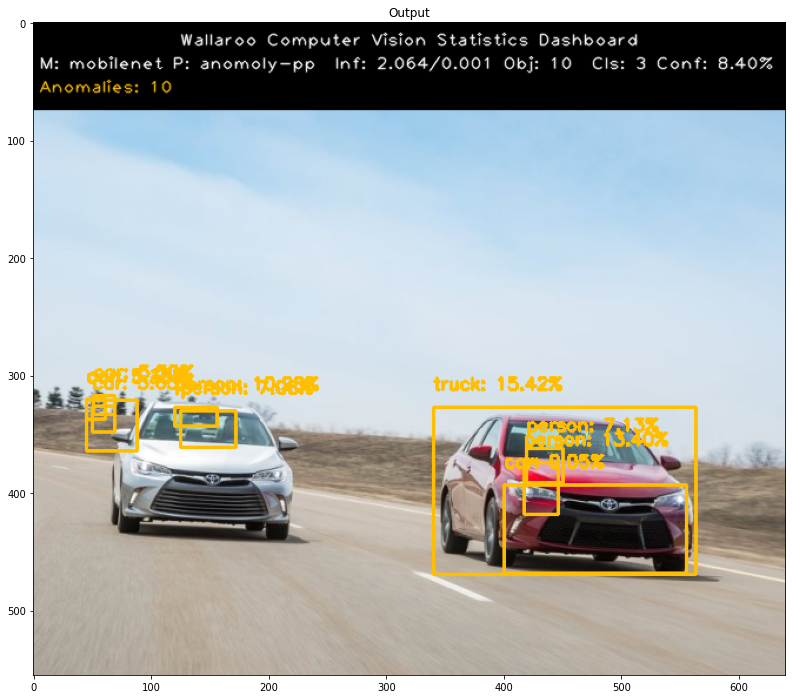

In [14]:
# Reload the sample image
tensor, resizedImage = cvDemo.loadImageAndResize(imagePath, width, height)

amber = (0,191,255)
red = (0,0,255)
blue = (255,0,0)
black = (0,0,0)

results = {
    'model_name' : model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,    'image' : resizedImage,
    'classes' : anomolyClasses,
    'confidences' : anomolyConfidences,
    'anomaly-count' : len(anomolyConfidences),
    'boxes' : anomolyBoxes,
    'confidence-target' : 0.0,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(results['elapsed']) / 1e+9,                
    'color': CVDemo.AMBER
}

image = cvDemo.drawAndDisplayDetectedObjectsWithClassification(results)

In [ ]:

pipeline.undeploy()
#for d in wl.list_deployments():
#    d.undeploy()
    